# House price prediction

We use the classic [house price dataset from kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) to fit a simple linear regression model to predict house price.

This notebook has code for ridge regression, gradient descent and cross validation coded from scratch.

In [ ]:
# import dependancies
import numpy as np
import pandas as pd
import scipy
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

import matplotlib.pylab as plt
import seaborn as sns;
sns.set_context('poster')
sns.set_style('darkgrid')

In [29]:
warnings.simplefilter("ignore")

# Read in data and drop nans
df = pd.read_csv('kc_house_data.csv')
df.dropna(axis=0, how='any', inplace=True)
# Drop date and zipcode as we will not use them in the analysis
df.drop(labels=['date','zipcode'],axis=1, inplace=True)
# Create development dataset "df" and test dataset "df_test" 
df, df_test = train_test_split(df, test_size=0.1)
df.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

# Create a matrix from the columns of the development dataset
# and scale these columns 
# Apply the same scaling to the test set
cols = [i for i in list(df.columns) if i not in ['id','price']]
x_dev = df.as_matrix(columns=cols)
x_test = df_test.as_matrix(columns=cols)
# Fit scaler only on dev set only
scaler = StandardScaler().fit(x_dev)
df.drop(labels=cols,axis=1,inplace=True)
df_test.drop(labels=cols,axis=1,inplace=True)
for col in cols:
    df[col] = scaler.fit_transform(x_dev[:,cols.index(col)].reshape(-1,1))
    df_test[col] = scaler.fit_transform(x_test[:,cols.index(col)].reshape(-1,1))
    

df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,6821101275,478000.0,-1.472565,-0.474640,-0.132625,-0.221014,-0.913763,-0.087264,-0.30537,0.914742,-0.558613,-0.978139,1.555070,-2.287865,-0.211648,0.669219,-1.327226,-0.491792,-0.252577
1,1703900005,465000.0,-0.398350,-1.448845,-0.950584,-0.247904,-0.913763,-0.087264,-0.30537,0.914742,-1.408550,-0.700196,-0.660605,-0.752557,-0.211648,-0.037885,-0.418208,-1.337404,-0.293886
2,7852150120,384000.0,-0.398350,0.499565,-0.416184,-0.268692,0.936112,-0.087264,-0.30537,-0.626147,-0.558613,-0.108057,-0.660605,1.089814,-0.211648,-0.199509,2.436678,-0.418895,-0.310549
3,1822069052,450000.0,1.750079,0.499565,0.838020,4.630729,-0.913763,-0.087264,-0.30537,0.914742,-0.558613,0.169886,1.419416,-1.571388,4.655186,-1.201000,0.888506,0.339240,7.200761
4,6752500090,1835000.0,0.675864,1.798506,3.041057,0.570195,0.936112,-0.087264,-0.30537,-0.626147,3.691069,3.722723,-0.660605,0.816870,-0.211648,-0.112925,0.639946,4.392343,0.768433


In [31]:
df.shape

(19451, 19)

corr between price and bedrooms : 0.307105705145


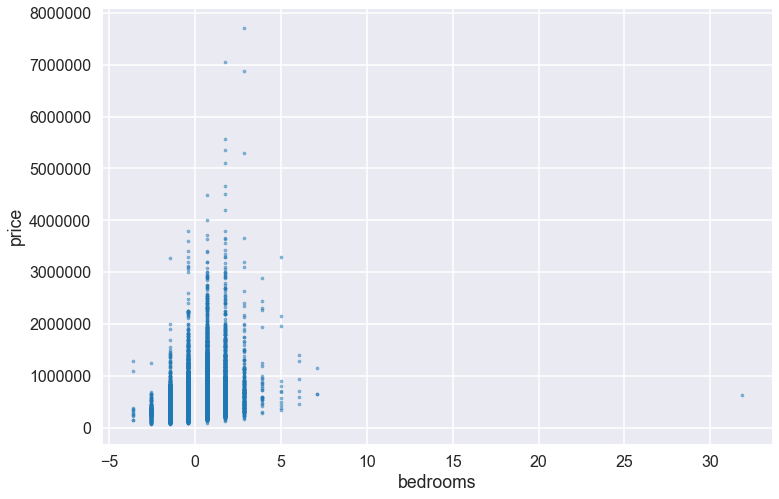

corr between price and bathrooms : 0.526567940646


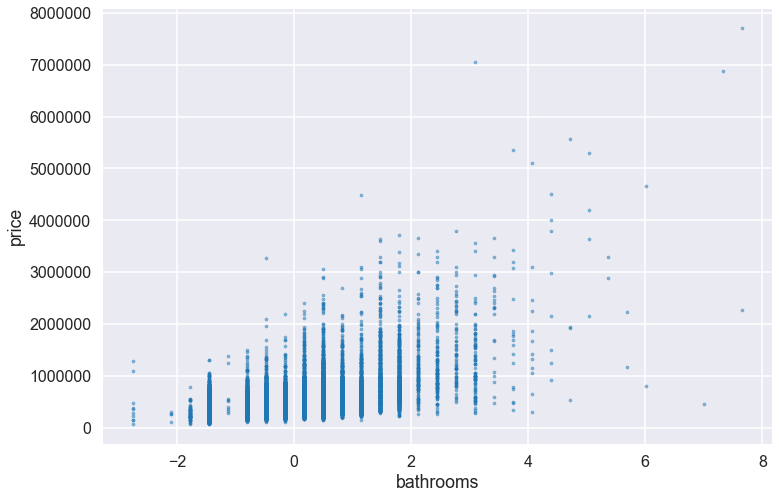

corr between price and sqft_living : 0.702898552324


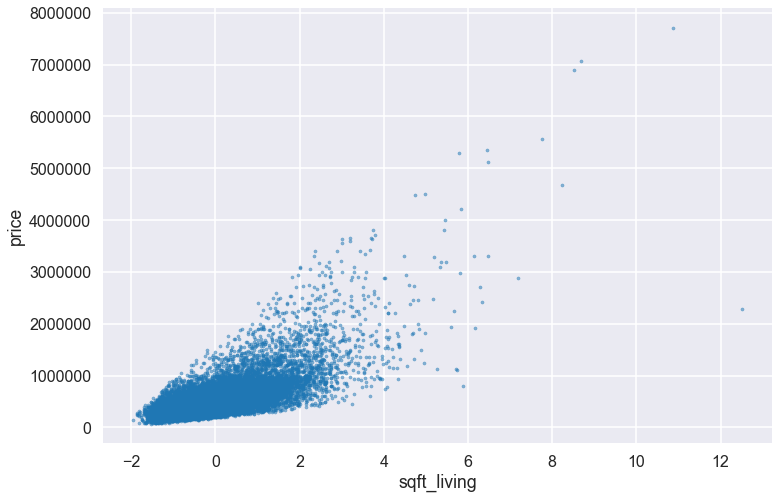

corr between price and sqft_lot : 0.0831137310583


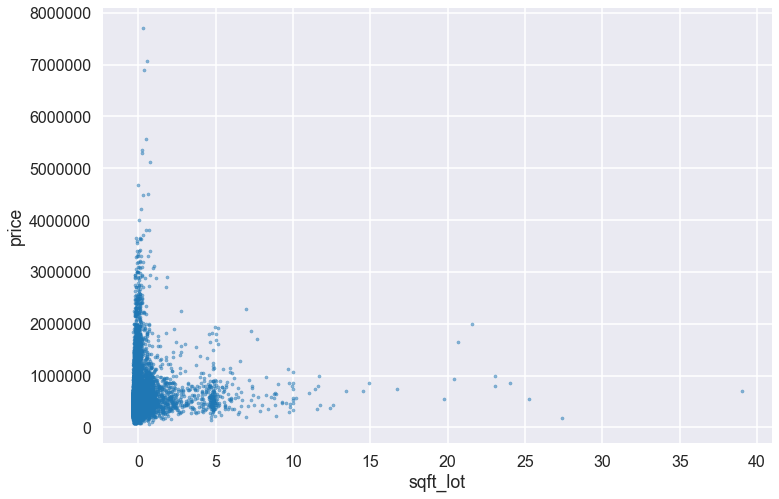

corr between price and floors : 0.25813873662


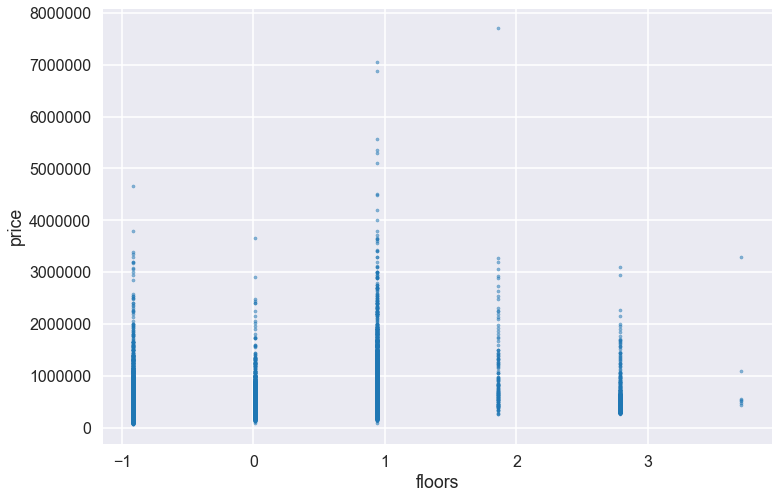

corr between price and waterfront : 0.263732646003


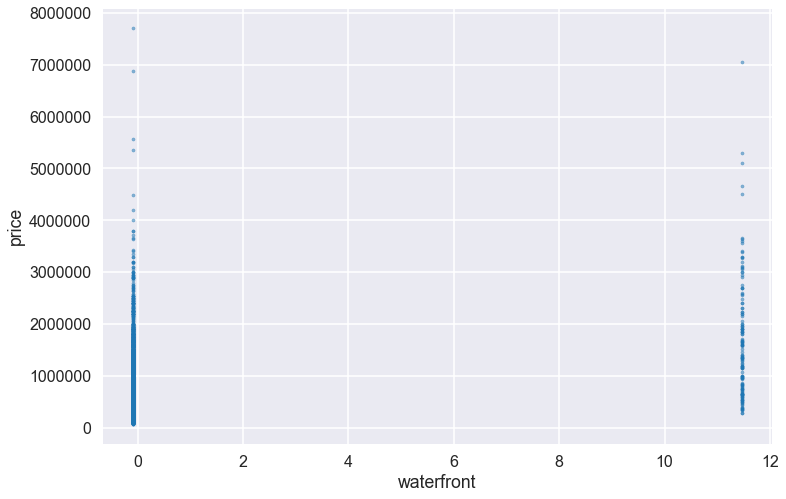

corr between price and view : 0.394694381975


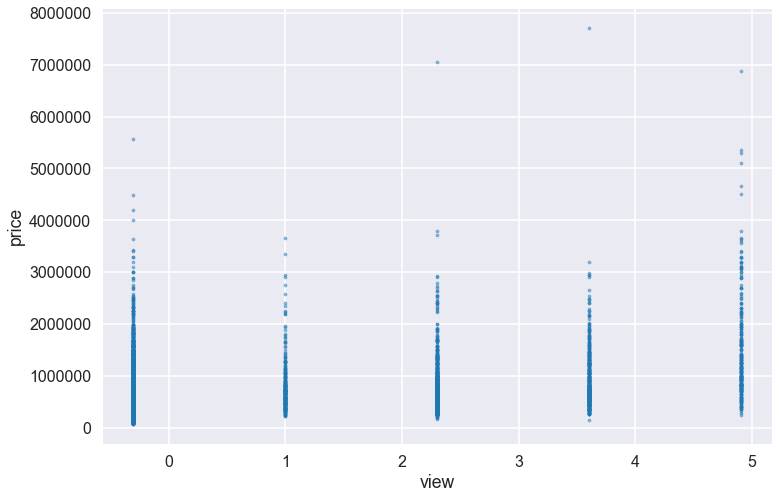

corr between price and condition : 0.0346952738652


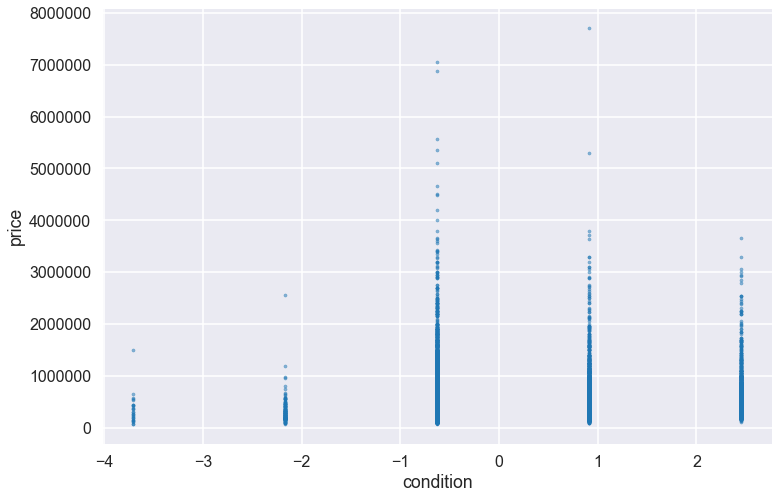

corr between price and grade : 0.665379236401


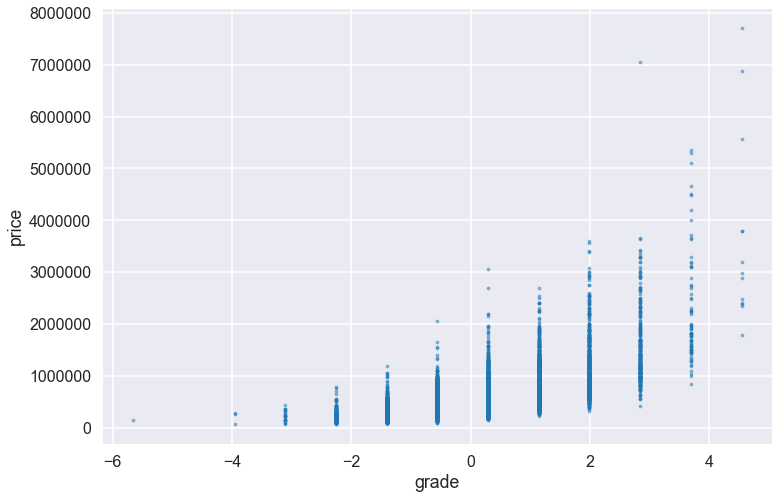

corr between price and sqft_above : 0.605649601565


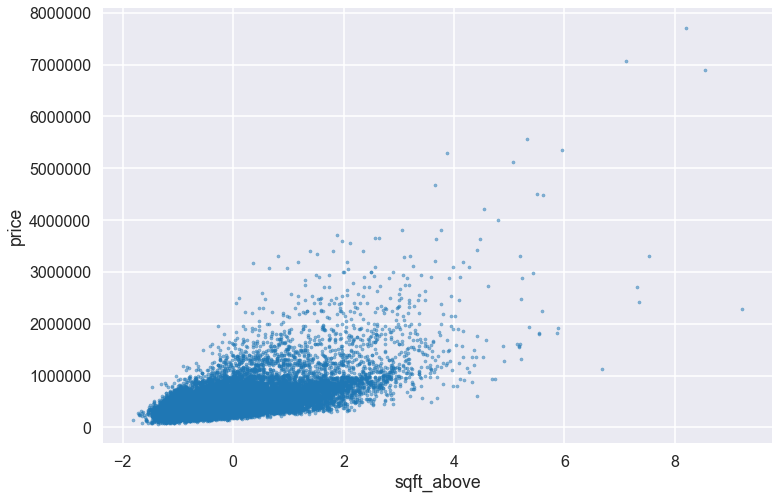

corr between price and sqft_basement : 0.324029542894


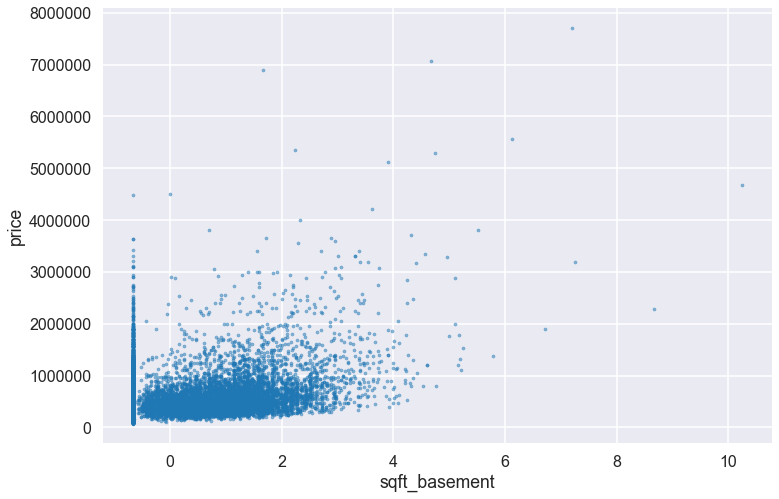

corr between price and yr_built : 0.0558538695975


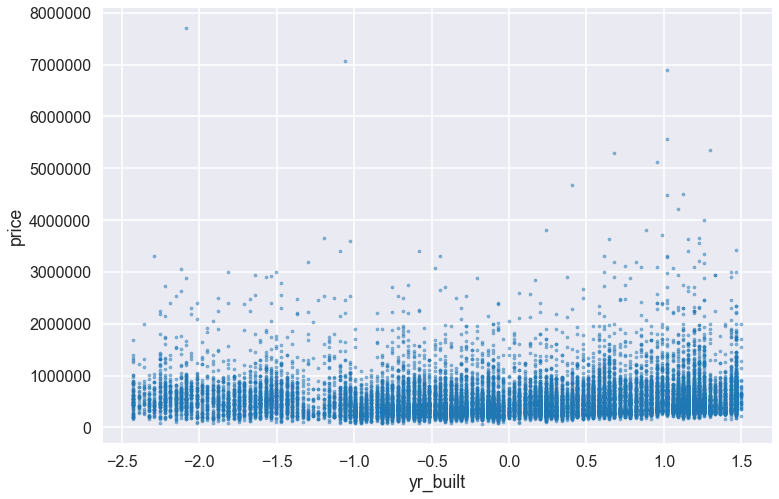

corr between price and yr_renovated : 0.127431914472


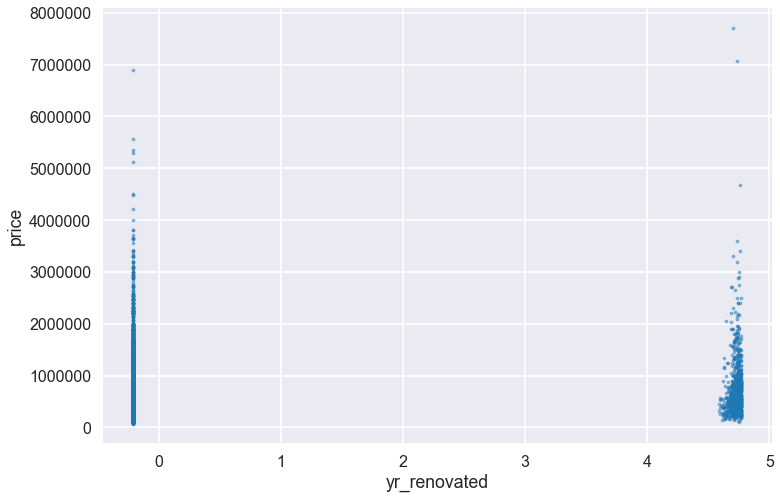

corr between price and lat : 0.306208124743


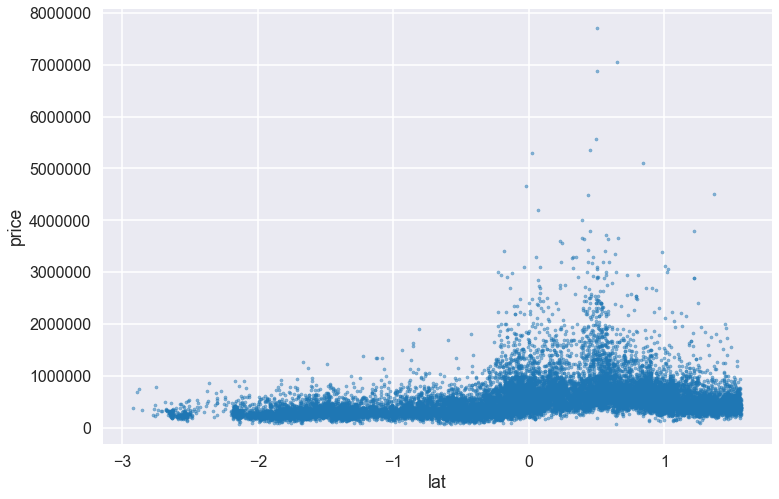

corr between price and long : 0.0218306713073


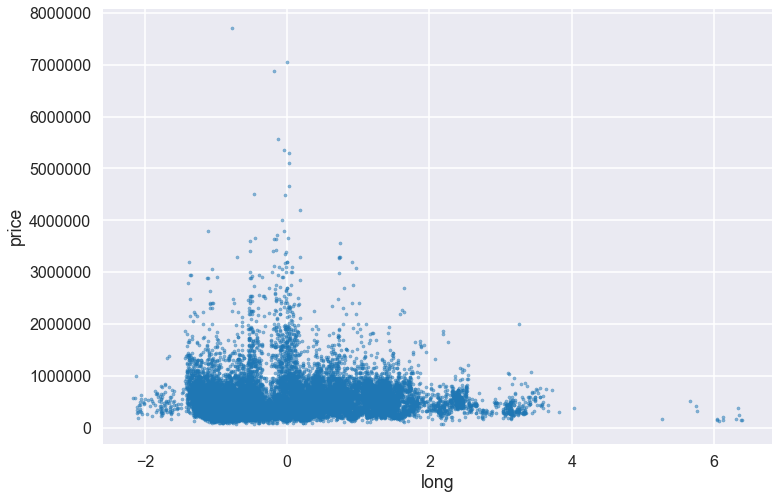

corr between price and sqft_living15 : 0.584217702319


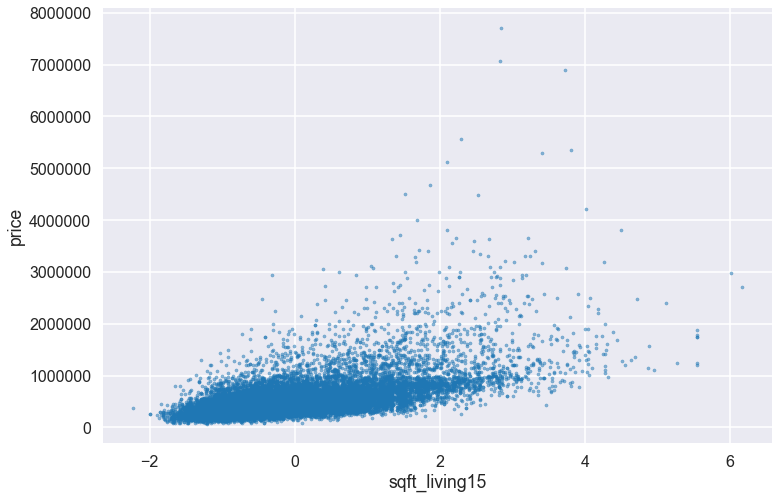

corr between price and sqft_lot15 : 0.076613483646


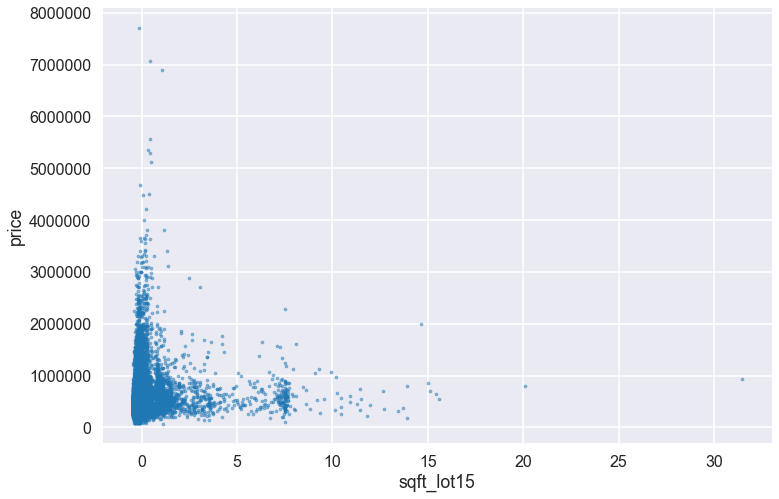

In [32]:
for col in cols:
    fig, ax = plt.subplots(figsize=(12,8))
    df.plot(kind='scatter', x=col, y='price', ax=ax, s=10, alpha=0.5)
    print("corr between price and", col,":",pearsonr(df[col].values, df.price.values)[0])
    plt.show()

# Check for covariance between features

We don't want correlated features in our model, as this makes the features redundant and could reduce the performance of the model.

In [33]:
x_check_cov = df.as_matrix(columns=cols)
x_check_cov.shape

(19451, 17)

In [34]:
Sigma = (1/x_check_cov.shape[0])*np.dot(x_check_cov.T,x_check_cov)
Sigma = abs(Sigma)

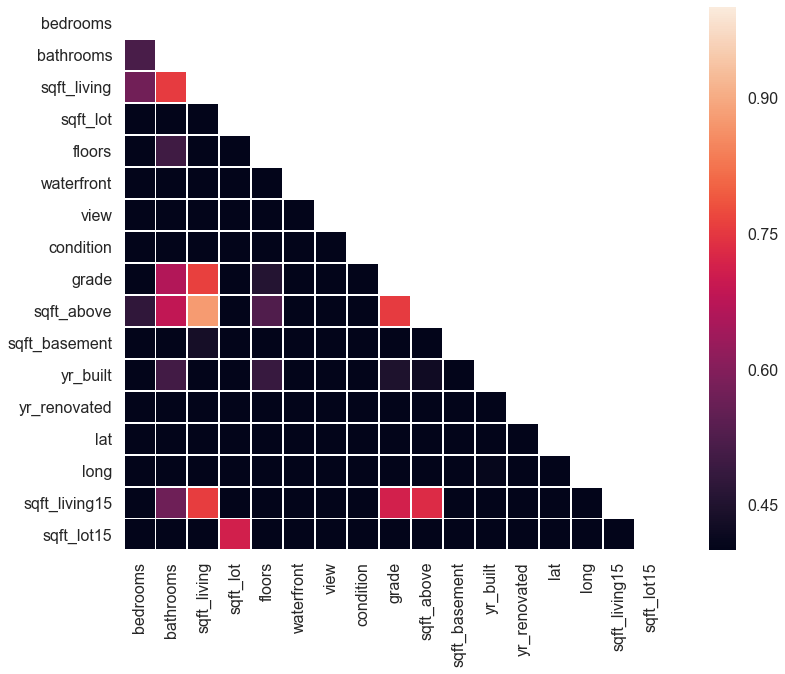

In [35]:
mask = np.zeros_like(Sigma)
mask[np.triu_indices_from(Sigma)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(Sigma, mask=mask, square=True, vmin=0.4, ax=ax, linewidths=1, xticklabels=cols, yticklabels=cols)
    plt.show()

### Some features are correlated

We see features such as sqft_above and sqft_lving are highly correlated (almost 0.8). We will get rid of redundant features.

In [36]:
discard_cols = ['grade','bathrooms','sqft_above','sqft_lot','sqft_lot15']
cols = [i for i in list(df.columns) if i not in discard_cols]
df.drop(labels=discard_cols,axis=1,inplace=True)
df_test.drop(labels=discard_cols,axis=1,inplace=True)
df.head()

,id,price,bedrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15
0,6821101275,478000.0,-1.472565,-0.132625,-0.913763,-0.087264,-0.30537,0.914742,1.555070,-2.287865,-0.211648,0.669219,-1.327226,-0.491792
1,1703900005,465000.0,-0.398350,-0.950584,-0.913763,-0.087264,-0.30537,0.914742,-0.660605,-0.752557,-0.211648,-0.037885,-0.418208,-1.337404
2,7852150120,384000.0,-0.398350,-0.416184,0.936112,-0.087264,-0.30537,-0.626147,-0.660605,1.089814,-0.211648,-0.199509,2.436678,-0.418895
3,1822069052,450000.0,1.750079,0.838020,-0.913763,-0.087264,-0.30537,0.914742,1.419416,-1.571388,4.655186,-1.201000,0.888506,0.339240
4,6752500090,1835000.0,0.675864,3.041057,0.936112,-0.087264,-0.30537,-0.626147,-0.660605,0.816870,-0.211648,-0.112925,0.639946,4.392343


# Regularized Ridge Regression


We'll be implmenting L2 regularized regression form scratch, using mini-batch (stochastic) gradient descent. The cost function of the model is given by

$$J(W) = \frac{1}{2m}\sum_{i=1}^m (XW - y)^2 + \frac{\lambda}{2m}\sum_{i=1}^nW^2$$

where $X$, $W$, $y$, $\lambda$ and $m$ are the data, model weights, targets, regression penalty and number of data points respectively.

To tune the hyperparameters, we will implement cross validation on a validation set.

Finally, at the end we will train a model on a simpler dataset, only including the sqft_area feature and comparing the SSE of the simpler model to the SSE of the more complex model with more features.

In [121]:
class RidgeGD:
    """
    Performs ridge regression on a dataset with L2 regularization
    """
    
    def __init__(self,lambda_=1,alpha=0.01, batchSize=32,n_iter=100,output_every=10):
        self.lambda_        = lambda_ # the penalty / regularization size
        self.alpha          = alpha # the learning rate
        self.batchSize      = batchSize # the size mini batch for gradient descent
        self.n_iter         = n_iter # the numner of iterations in mini batch gradient descent
        self.output_every   = output_every # how often to print error
        
    def cost(self,x,y,w):
        """
        Calculate the cost with current weights
        INPUT: data x, targets y, weights w
        OUTPUT: cost
        """
        # X ~ mxn
        # y ~ mx1
        # W ~ nx1
        m = x.shape[0]
        h = np.dot(x,w) # mxn * nx1 = mx1
        error = h - y
        w[0] = 0 # dont regularize bias
        J = (1/(2*m))*np.sum(error**2) + (self.lambda_/(2*m))*np.sum(w**2)
        return J
     
    def grad(self,x,w,y):
        """
        Calculate the gradient of the cost function
        INPUT: data x, targets y, weights w
        OUTPUT: gradient of cost function
        """
        m = x.shape[0]
        h = np.dot(x,w)
        error = h - y # mx1
        w[0] = 0 # dont regularize bias term
        partial = (1/m)*np.dot(x.T,error) + (self.lambda_/m)*w # nx1
        return partial
    
    def update_weights(self,x,w,y):
        """
        Update the model weights
        INPUT: data x, targets y, current weights w
        OUTPUT: updated weights
        """
        partial = self.grad(x,w,y)
        w = w - self.alpha*partial
        return w
    
    def get_mini_batch(self,x,y,i):
        """
        Get a minibatch of the data
        INPUT: data x, targets y, iteration i
        OUTPUT: subset of the data X,y
        """
        x_mini = x[i*self.batchSize:(i+1)*self.batchSize,:]
        y_mini = y[i*self.batchSize:(i+1)*self.batchSize,:]
        return x_mini,y_mini
    
    def add_bias(self,x):
        """
        Add a column of 1's as the first column in the data x
        INPUT: data x
        OUTPUT: data x with a column of 1's as first column
        """
        x_bias = np.ones((x.shape[0],1))
        x = np.concatenate((x_bias,x),axis=1)
        return x
    
    def init_weights(self,x):
        """
        Initialize the model weights at random
        INPUT: data x
        OUTPUT: random weights
        """
        return (np.random.random((x.shape[1],1))*2 - 1)*1e-2
    
    def fit(self,x,y):
        """
        Fit a model to the data using mini batch gradient descent
        INPUT: data x, targets y
        OUTPUT: model weights w
        """
        if np.all(x[:,0] == np.ones(x.shape[0])):
            pass
        else:
            x = self.add_bias(x)
            
        w = self.init_weights(x)
        n = np.arange(len(x))
        
        """
        Perform mini batch gradient descent
        """
        J = []
        for epoch in range(1, self.n_iter + 1):
            for i in range(0,round(x.shape[0]/self.batchSize)):
                X_mini,Y_mini = self.get_mini_batch(x=x,y=y,i=i)
                J.append(self.cost(x=X_mini,y=Y_mini,w=w))
                w = self.update_weights(x=x,w=w,y=y)

        return w
    
    def predict(self,x,w):
        """
        Predict the target of new input data
        INPUT: data x, learned weights w
        OUTPUT: predicted targets
        """
        x_bias = np.ones((x.shape[0],1))
        x = np.concatenate((x_bias,x),axis=1)
        return np.dot(x,w)

# SSE

Sum of squared error (SSE), is defined as follows

$$\text{SSE} = \sum_{i=1}^{m}(y_i - \hat{y_i})^2$$

where $y_i$ is the true target value, and $\hat{y_i}$ is the predicted target value.

We will use SSE as a metric for the error of a model, and compare SSE values to determine the bets model hyperparameters and best ultimate model.

In [325]:
# The features we will be using to predict price
[col for col in list(df.columns) if col not in ['id','price']]

['bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15']

In [123]:
# Create matrices X and Y for training and testing
X = df.as_matrix(columns=[col for col in list(df.columns) if col not in ['id','price']])
Y = df.as_matrix(columns=['price'])
X_test = df_test.as_matrix(columns=[col for col in df_test if col not in ['id','price']])
Y_test = df_test.as_matrix(columns=['price'])

In [308]:
def CrossValidate(x,y,alpha,lambda_):
    """
    Use cross validation on the development data set to obtain the optimal hyperparameters
    INPUT: data x, targets y, alpha (start, end, num), lambda (start, end, num)
    OUTPUT: errs_dict, a dictionary of (alpha,lambda) keys and SSE error values
    """
    
    alphas = np.linspace(alpha[0],alpha[1],alpha[2])
    lambdas_ = np.logspace(lambda_[0],lambda_[1],lambda_[2])
    
    # Use k-fold (10-fold) cross val
    k=10
    cv = KFold(n_splits=k, shuffle=False)
    train_indices = [i[0] for i in cv.split(x)]
    val_indices = [i[1] for i in cv.split(x)]
    
    errs_dict = {(a,l):0 for a,l in zip(alphas,lambdas_)}

    # Loop over alphas and lambdas hyperparams
    for a in alphas:
        print("alpha:",a)
        for lam in lambdas_:
            cv_sse_err = []
            for i in range(k):
                
                x_train = x[train_indices[i],:]
                y_train = y[train_indices[i],:]
                
                x_val = x[val_indices[i],:]
                y_val = y[val_indices[i],:]
                
                model = RidgeGD(lambda_=lam, alpha=a, batchSize=64, n_iter=50, output_every=50)
                W = model.fit(x=x_train,y=y_train)
                
                sse = sum((model.predict(x_val,W) - y_val)**2)[0]
                cv_sse_err.append(sse)
                
            errs_dict[(a,lam)] = (1/k)*sum(cv_sse_err)
    
    return errs_dict

In [159]:
# This takes about 10 minutes to run
errs_dict = CrossValidate(X,Y,(0.5,0.69,5),(1,2,5))

alpha: 0.5
alpha: 0.5475
alpha: 0.595
alpha: 0.6425
alpha: 0.69


In [161]:
# Use the minimum value to train the final model
min(errs_dict, key=errs_dict.get)

(0.64249999999999996, 31.622776601683793)

In [328]:
# Train model with optimim hyperparams above
model = RidgeGD(lambda_=32,alpha=0.64, batchSize=64, n_iter=100, output_every=50)
# Model weights
W = model.fit(x=X,y=Y)

In [329]:
# Calculate the sse on the test set
sse_all_features = sum((Y_test - model.predict(X_test,W))**2)[0]
sse_all_features

155327864893519.5

In [330]:
sstot_all_features = sum((Y_test - np.mean(Y_test))**2)[0]
sstot_all_features

254657177398875.53

In [331]:
rsq = 1 - sse_all_features/sstot_all_features
rsq

0.3900511013273904

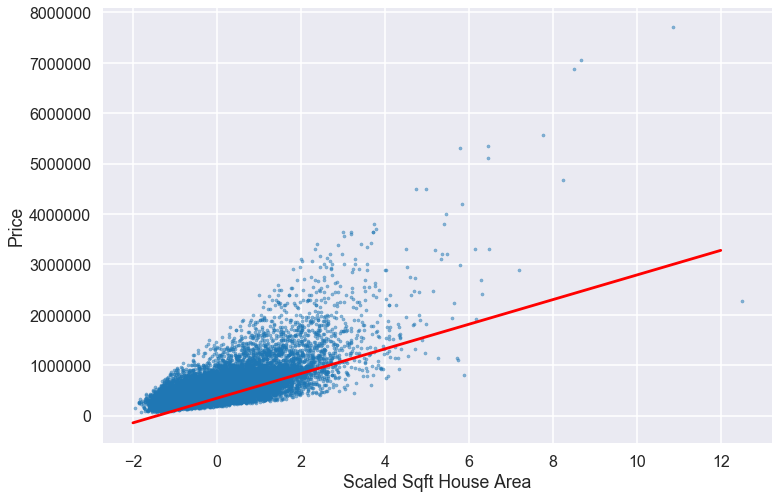

In [240]:
def line(m,b,x):
    """
    Return the points on a line
    INPUT: m (line slope), b (line intersect / bias), x (x values of the line)
    OUTPUT: an array of y values for every corresponding x value
    """
    return m*x+b

# Plot appropriate weights and biases and data to see how well line fits through data
l = line(m=W[2],b=W[0],x=np.linspace(-2,12,1000))
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,1],Y,s=10,alpha=0.5)
ax.plot(np.linspace(-2,12,1000),l,color='r')
ax.set_ylabel("Price")
ax.set_xlabel("Scaled Sqft House Area")
plt.show()

## Conclusions

The model seems to perform relatively well, although the red line above is actually a hyperplane going through the data in multiple dimensions, so it is hard to tell how well it fits to the data in all dimensions.

We will train a model on a simpler dataset, using only the sqft_area feature of the original dataset and calculating the SSE of the model.

# Simpler Model -  sqft_area feature only

In [341]:
# Create simple dataset
# First, cross validate the model to find optimum hyperparms
df_remove_outlier = df[df['price'] < 3000000]
df_remove_outlier = df_remove_outlier[df_remove_outlier['sqft_living'] < 6]
df_remove_outlier.reset_index(inplace=True,drop=True)
X_simple = df_remove_outlier.as_matrix(columns=['sqft_living'])
errs_dict = CrossValidate(X_simple,Y,(0.98,1.3,5),(1,2,5))

alpha: 0.98
alpha: 1.06
alpha: 1.14
alpha: 1.22
alpha: 1.3


In [342]:
# Use these optimum hyperparams in simple model
min(errs_dict, key=errs_dict.get)

(0.97999999999999998, 100.0)

In [344]:
Y = df_remove_outlier.as_matrix(columns=['price'])
model_simple = RidgeGD(lambda_=100, alpha=1, batchSize=64, n_iter=100, output_every=50)
W_simple = model_simple.fit(x=X_simple,y=Y)

In [345]:
# Make a test data set using only sqft_living
X_test_simple = df_test.as_matrix(columns=['sqft_living'])

In [346]:
# Calculate the SSE of the simple model
sse_simple = sum((Y_test - model_simple.predict(X_test_simple,W_simple))**2)[0]
sse_simple

131670441602264.52

In [347]:
sstot_simple = sum((Y_test - np.mean(Y_test))**2)[0]
sstot_simple

254657177398875.53

In [348]:
rsq = 1 - sse_simple/sstot_simple
rsq

0.48295020408544775

In [349]:
# The simple model has an SSE 0.85 times the size of the model using all features
sse_simple/sse_all_features

0.84769362981025564

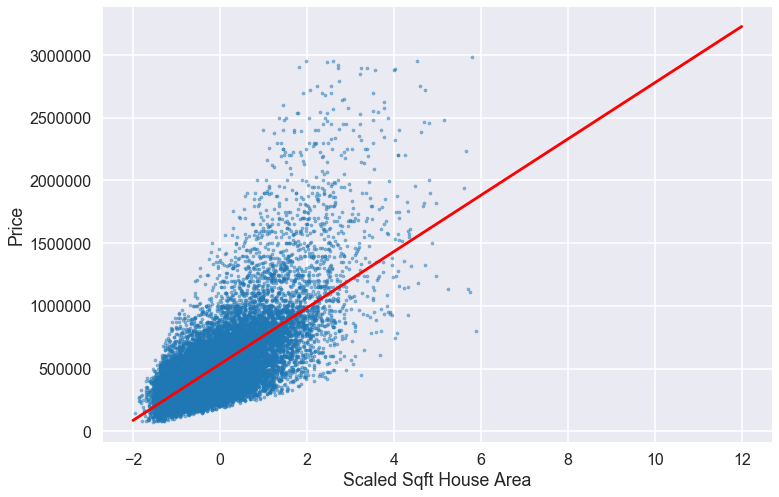

In [351]:
# Plot appropriate weights and biases and data to see how well line fits through data
l = line(m=W_simple[1],b=W_simple[0],x=np.linspace(-2,12,1000))
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(X_simple,Y,s=10,alpha=0.5)
ax.plot(np.linspace(-2,12,1000),l,color='r')
ax.set_ylabel("Price")
ax.set_xlabel("Scaled Sqft House Area")
plt.show()

# Conclusion

The simpler model, using only sqft_area, performed better than the complex model using all the features. The simpler model had an SSE that was 0.85 the size of the SSE of the complex model.

This may be a result of the complex model trying to fit to the data in higher dimensions, but the fit not being optimal due to the structure of the data in higher dimensions.

Occam's razor tells us that a simpler solution is usually the correct solution, and with this particular dataset, that certainly seems to be the case.